In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

plt.style.use("seaborn-v0_8")


In [2]:
ticker = "GBPUSD=X"
df = yf.download(ticker, start="2010-01-01", end="2025-01-01")
df.head()


C:\Users\User\AppData\Local\Temp\ipykernel_11624\1834745182.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2010-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GBPUSD=X,GBPUSD=X,GBPUSD=X,GBPUSD=X,GBPUSD=X
Date,,,,,
2010-01-01,1.613294,1.618202,1.613111,1.618202,0
2010-01-04,1.611370,1.623904,1.606503,1.613710,0
2010-01-05,1.599079,1.615587,1.597010,1.611863,0
2010-01-06,1.602384,1.606323,1.594388,1.599360,0
2010-01-07,1.593397,1.605858,1.590078,1.602205,0


In [3]:
df["return_1d"] = np.log(df["Close"] / df["Close"].shift(1))
df["volatility_5"] = df["return_1d"].rolling(5).std()
df["momentum_3"] = df["Close"].pct_change(3)
df["momentum_7"] = df["Close"].pct_change(7)
df["ma_5"] = df["Close"].rolling(5).mean()
df["ma_20"] = df["Close"].rolling(20).mean()
df["ma_ratio"] = df["ma_5"] / df["ma_20"]

df["target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

df.dropna(inplace=True)
df = df.iloc[:-1]

df.head()


Price,Close,High,Low,Open,Volume,return_1d,volatility_5,momentum_3,momentum_7,ma_5,ma_20,ma_ratio,target
Ticker,GBPUSD=X,GBPUSD=X,GBPUSD=X,GBPUSD=X,GBPUSD=X,,,,,,,,
Date,,,,,,,,,,,,,
2010-01-28,1.614309,1.627631,1.611603,1.617809,0,-0.002165,0.006235,-0.006586,-0.013060,1.616567,1.617076,0.999685,0
2010-01-29,1.598491,1.617940,1.598312,1.614674,0,-0.009847,0.007222,-0.010039,-0.019214,1.614064,1.616336,0.998595,0
2010-02-01,1.595253,1.597699,1.585464,1.597393,0,-0.002028,0.004519,-0.013943,-0.015586,1.608112,1.615530,0.995409,1
2010-02-02,1.599207,1.599565,1.590811,1.595100,0,0.002476,0.004925,-0.009355,-0.007324,1.605014,1.615536,0.993487,0
2010-02-03,1.592002,1.606994,1.588512,1.599309,0,-0.004516,0.004488,-0.004060,-0.020314,1.599852,1.615017,0.990610,0


In [4]:
feature_cols = ["return_1d", "volatility_5",
                "momentum_3", "momentum_7", "ma_ratio"]

X = df[feature_cols]
y = df["target"]

split_index = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

X_train.shape, X_test.shape


((3110, 5), (778, 5))

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
log_pred = log_model.predict(X_test_scaled)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_split=5,
    random_state=42
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


In [7]:
print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, log_pred))
print(classification_report(y_test, log_pred))

print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))


=== Logistic Regression ===
Accuracy: 0.5012853470437018
              precision    recall  f1-score   support

           0       0.50      0.65      0.56       387
           1       0.51      0.36      0.42       391

    accuracy                           0.50       778
   macro avg       0.50      0.50      0.49       778
weighted avg       0.50      0.50      0.49       778


=== Random Forest ===
Accuracy: 0.5308483290488432
              precision    recall  f1-score   support

           0       0.53      0.60      0.56       387
           1       0.54      0.47      0.50       391

    accuracy                           0.53       778
   macro avg       0.53      0.53      0.53       778
weighted avg       0.53      0.53      0.53       778



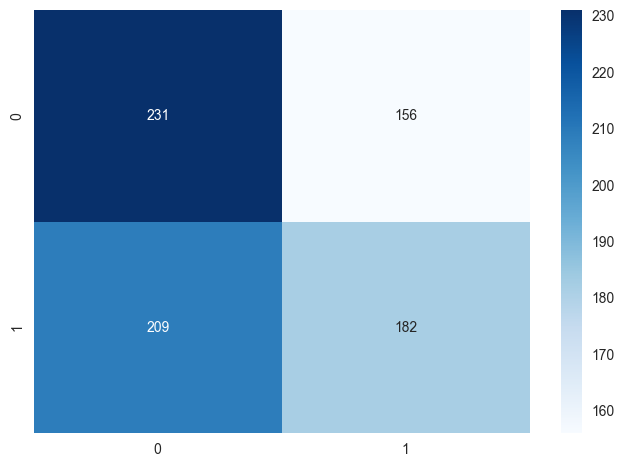

,feature,importance
1,volatility_5,0.203957
4,ma_ratio,0.200992
3,momentum_7,0.200200
2,momentum_3,0.198209
0,return_1d,0.196641


In [8]:
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

feat_imp = pd.DataFrame({
    "feature": feature_cols,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

feat_imp


In [9]:
last_row = X.tail(1)

log_next = log_model.predict(scaler.transform(last_row))[0]
rf_next = rf_model.predict(last_row)[0]

print("Logistic Regression:", "UP" if log_next else "DOWN")
print("Random Forest:", "UP" if rf_next else "DOWN")


Logistic Regression: UP
Random Forest: UP


In [10]:
# -------------------------------
# 10. PROBABILITY OUTPUTS
# -------------------------------

# Predict probability of UP-move for both models
log_prob = log_model.predict_proba(X_test_scaled)[:, 1]
rf_prob  = rf_model.predict_proba(X_test)[:, 1]

# Attach probabilities to a result dataframe
df_test = df.iloc[split_index:].copy()
df_test["log_prob_up"] = log_prob
df_test["rf_prob_up"]  = rf_prob

df_test[["Close", "target", "log_prob_up", "rf_prob_up"]].head()


Price,Close,target,log_prob_up,rf_prob_up
Ticker,GBPUSD=X,,,
Date,,,,
2022-01-06,1.355565,0,0.481261,0.519675
2022-01-07,1.353363,1,0.474138,0.510406
2022-01-10,1.359231,0,0.475683,0.521985
2022-01-11,1.358031,1,0.478355,0.511839
2022-01-12,1.363327,1,0.471426,0.522661


AUC Logistic Regression: 0.517013950844915
AUC Random Forest: 0.5329275626664551


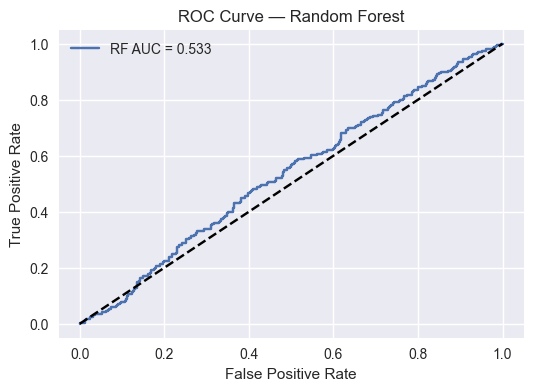

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve

auc_lr = roc_auc_score(y_test, log_prob)
auc_rf = roc_auc_score(y_test, rf_prob)

print("AUC Logistic Regression:", auc_lr)
print("AUC Random Forest:", auc_rf)

# Plot ROC curve for Random Forest
fpr, tpr, thresholds = roc_curve(y_test, rf_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"RF AUC = {auc_rf:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest")
plt.legend()
plt.show()


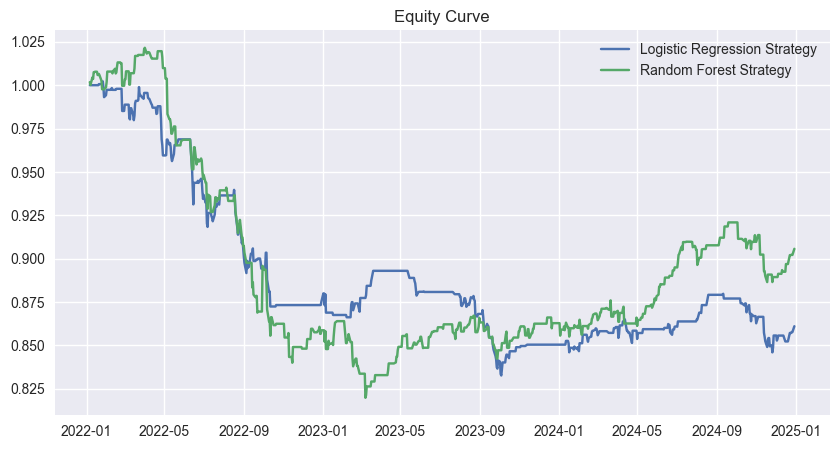

In [12]:
df_test["pred_lr"] = log_pred
df_test["pred_rf"] = rf_pred

# Strategy returns
df_test["lr_strategy"] = df_test["pred_lr"] * df_test["return_1d"]
df_test["rf_strategy"] = df_test["pred_rf"] * df_test["return_1d"]

# Cumulative returns
df_test["lr_cumret"] = (1 + df_test["lr_strategy"]).cumprod()
df_test["rf_cumret"] = (1 + df_test["rf_strategy"]).cumprod()

# Plot equity curves
plt.figure(figsize=(10,5))
plt.plot(df_test["lr_cumret"], label="Logistic Regression Strategy")
plt.plot(df_test["rf_cumret"], label="Random Forest Strategy")
plt.title("Equity Curve")
plt.legend()
plt.show()


In [13]:
sharpe_lr = df_test["lr_strategy"].mean() / df_test["lr_strategy"].std() * np.sqrt(252)
sharpe_rf = df_test["rf_strategy"].mean() / df_test["rf_strategy"].std() * np.sqrt(252)

print("Sharpe Logistic:", sharpe_lr)
print("Sharpe RF:", sharpe_rf)


Sharpe Logistic: -1.0733755168613734
Sharpe RF: -0.5311756772379885
